In [92]:
import h5py
import tensorflow as tf
import keras as keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from PIL import Image
import cv2

In [93]:
length = 17736

In [94]:
# Classes:
"""
Irregular: 0
Merging: 1
Smooth/Round: 2
Spiral: 3
Edge-On: 4
"""

'\nIrregular: 0\nMerging: 1\nSmooth/Round: 2\nSpiral: 3\nEdge-On: 4\n'

In [95]:
with h5py.File('/Users/harismahmood/Downloads/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

In [96]:
# Gray Scaling

gray_images = []
for i in range(len(images)):
    gray_img = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)
    
images = np.array(gray_images)

In [97]:
# normalize images
images = images / 255

In [98]:
# Resize images to 64x64
images_resized = np.array([resize(img, (128, 128)) for img in images])

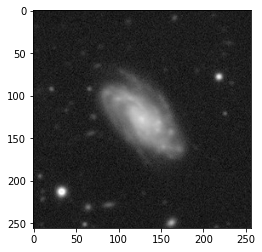

6


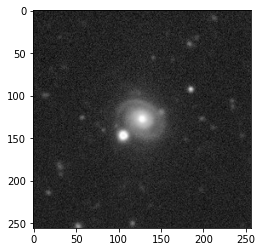

6


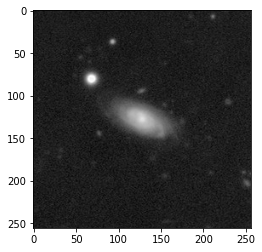

6


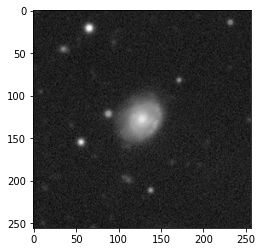

6


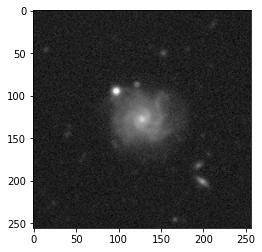

6


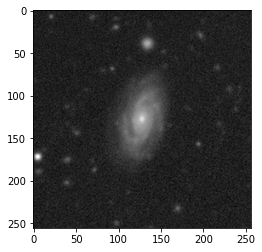

6


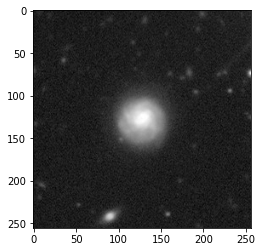

6


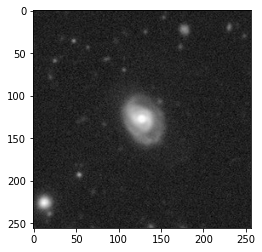

6


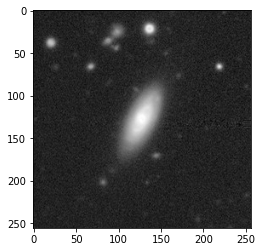

6


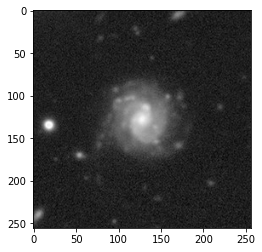

6


In [99]:
startind = 10000
for i in range(startind, startind+10):
    plt.imshow(images[i], cmap='gray')
    plt.show()
    print(labels[i])

In [100]:
# Reducing number of classifications
for i in range(len(labels)):
    if labels[i] == 3 or labels[i] == 4:
        labels[i] = 2
    if labels[i] == 5 or labels[i] == 6 or labels[i] == 7:
        labels[i] = 3
    if labels[i] == 8 or labels[i] == 9:
        labels[i] = 4

In [101]:
# Split the data into a training set and a temporary set using the train_test_split function.
images_train, images_temp, labels_train, labels_temp = train_test_split(images_resized, labels, test_size=0.3, 
                                                                        random_state=42)

In [102]:
# Split the temporary set into a validation set and a test set.
images_val, images_test, labels_val, labels_test = train_test_split(images_temp, labels_temp, test_size=0.5, 
                                                                   random_state=42)

In [103]:
# Network Architecture
input_shape = (128, 128, 1) 

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 64)      

In [105]:
# One-hot encoding the labels
labels_train_encoded = to_categorical(labels_train)
labels_val_encoded = to_categorical(labels_val)
labels_test_encoded = to_categorical(labels_test)

In [106]:
# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Training the model
history = model.fit(images_train, labels_train_encoded, 
                    validation_data=(images_val, labels_val_encoded),
                    epochs=10, batch_size=32)

Epoch 1/10
388/388 [==============================] - 205s 520ms/step - loss: 1.2816 - accuracy: 0.5650 - val_loss: 24.0605 - val_accuracy: 0.1977
Epoch 2/10
388/388 [==============================] - 197s 507ms/step - loss: 0.9880 - accuracy: 0.6606 - val_loss: 0.9950 - val_accuracy: 0.6474
Epoch 3/10
388/388 [==============================] - 197s 507ms/step - loss: 0.8844 - accuracy: 0.6923 - val_loss: 3.0373 - val_accuracy: 0.3579
Epoch 4/10
388/388 [==============================] - 196s 505ms/step - loss: 0.8371 - accuracy: 0.7104 - val_loss: 1.1724 - val_accuracy: 0.6549
Epoch 5/10
388/388 [==============================] - 195s 503ms/step - loss: 0.8414 - accuracy: 0.7098 - val_loss: 1.0661 - val_accuracy: 0.6293
Epoch 6/10
388/388 [==============================] - 195s 504ms/step - loss: 0.7847 - accuracy: 0.7309 - val_loss: 1.1140 - val_accuracy: 0.6023
Epoch 7/10
388/388 [==============================] - 194s 501ms/step - loss: 0.7388 - accuracy: 0.7460 - val_loss: 0.8007 

In [110]:
# Testing
loss, accuracy = model.evaluate(images_test, labels_test_encoded)
print("Test Accuracy: ", accuracy)
print("Loss", loss)

84/84 [==============================] - 11s 136ms/step - loss: 0.8473 - accuracy: 0.7497
Test Accuracy:  0.7497181296348572
Loss 0.847283661365509


1/1 [==============================] - 0s 31ms/step
The predicted class is: 3


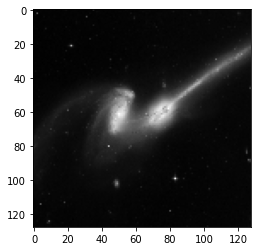

In [116]:
# New image testing 

def GalaxyPredict(file):
    
    # Load the image
    img = Image.open(file)
    
    # Numpy array conversion
    img = np.array(img)
    
    # Grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert the image to a numpy array and normalize it
    img = img / 255.0
    
    # Resize the image
    img = cv2.resize(img, (128, 128))  # Change this line

    # Add an extra dimension because the model expects a batch
    img_array = np.expand_dims(img, axis=0)

    #Predict galaxy
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    print("The predicted class is:", predicted_class)
    plt.imshow(img, cmap='gray')
    plt.show()

# ImageLoader('/Users/harismahmood/Downloads/merging gal.jpeg')
# ImageLoader('/Users/harismahmood/Downloads/irregullar gal.jpeg')
# ImageLoader('/Users/harismahmood/Downloads/Sombrero gal.jpeg')
# ImageLoader('/Users/harismahmood/Downloads/cat gal.jpeg')
GalaxyPredict('/Users/harismahmood/Downloads/merge1.jpeg')


In [109]:
# Classes:
"""
Irregular: 0
Merging: 1
Smooth/Round: 2
Spiral: 3
Edge-On: 4
"""

'\nIrregular: 0\nMerging: 1\nSmooth/Round: 2\nSpiral: 3\nEdge-On: 4\n'